## <center>Female Character Development in Movies - An Analysis using Bechdel Scores</center>



<b>Project background:</b> Happy Pride Month!! I originally wanted to analyze LQBTQIA+ presentation in Hollywood but wasn't able to find any freely available data on this. For example, glaad.org has [this great report](https://glaad.org/whereweareontv21) but unfortunately, the data behind the report is not freely available. So I'm focusing instead on gender based representation since this data is pretty easily available from [thebechdeltest](https://bechdeltest.com/). 

The Bechdel-Wallace Test or [(The Rule)](https://dykestowatchoutfor.com/the-rule/) as it was referred to by Alison Bechdel in the comic strip she created in 1985, asks three questions: (1) Are there at least two female characters in the movie?, (2) Are they shown talking to each other?, and (3) About something other than a man? The Bechdel-Wallace test has come to be one of the more well-known measures of female representation. Over the years, others have added further criteria to the test; this article by [ThirtyFiveEighty](https://projects.fivethirtyeight.com/next-bechdel/) talks about some of them. To keep things simple for my project, I'd like to stick to Bechdel scores.


<b>Datasets:</b> Three main datasets have been used for this project - (1) from [thebechdeltest.com](https://bechdeltest.com/api/v1/doc#getAllMovies), (2) from [imdb.com](https://developer.imdb.com/non-commercial-datasets/), and (3) from [the-numbers.com](https://www.the-numbers.com/box-office-records/domestic/all-movies/cumulative/all-time).


<b>Project Goals:</b> In this project I'm mainly asking the following questions:

* Using the Bechdel Test as a benchmark for representation of female characters in movies, do we see trends improving or deteriorating in Hollywood?

* Does the audience care; do movies that pass the Bechdel Test do better at the box office?

<b>Key Observations:</b>

For the first project goal, I'm happy to report that we see positive trends. Female representation in movies is appears to be improving over the years per the  Bechdel dataset as shown in Fig. 1 below. 

However, the Bechdel dataset does not represent the full universe of Hollywood movies; [the Bechdel dataset is created based on user submissions](https://bechdeltest.com/add/) and it is possible that only movies that do well on the Bechdel test are being reported. This would cause the Bechdel dataset to be biased and in such a case, the positive trends we see in this dataset may not converge with a broader and more representative dataset of Hollywood movies. See [Module 2](#m2) of this project for further details on how the representativeness of the Bechdel dataset based on a comparison against the IMDB dataset of US based English movies. Only 20% of the movies from the IMDB dataset were also found in the Bechdel dataset which would indicate that the Bechdel dataset is not fully representative of the universe of Hollywood movies from 1980 to 2022.

![YearlyBechdelScoreTrends_new](YearlyBechdelScoreTrends.png)

For the second project goal, in terms of box office returns, an analysis of the all time top 100 US movies by domestic box office returns revealed that 73% of these movies pass the Bechdel Test. While there are likely a lot of factors that go into making a movie a success, such as the budget, plot/genre, cast, etc. (analysis of which is beyond the scope of this project due to time and resource constraints), it appears that Bechdel scores are not strongly correlated with box office returns (correlation = ~0.2).

<img src="BScoreBOReturns.png" alt="drawing" width="40%"  height ="40%"/>

<b> References: </b>

1. https://glaad.org/whereweareontv21

2. https://dykestowatchoutfor.com/the-rule/

3. https://bechdeltest.com/

4. https://developer.imdb.com/non-commercial-datasets/

5. https://bechdeltest.com/api/v1/doc#getAllMovies

6. https://www.the-numbers.com/box-office-records/domestic/all-movies/cumulative/all-time

# 

# <center>Project Details </center>

<a id='m1'></a>
### Module 1: Bechdel Dataset based Analysis of Female Representation Trends

<a id='m1s1'></a>
<b> Section 1: Data Sourcing, Cleaning and Transformation</b>

I'm sourcing data via the bechdeltest.com API [here](https://bechdeltest.com/api/v1/doc#getAllMovies). All files have been saved locally to avoid repeated API calls but the code used for the API calls is available in the [appendix](#appendix1) if needed.

My extract as of June 2023 has data for about 10K movies from ~1870 to 2023. Since the Bechdel Test was created in the 80s, I'll be focusing my initial analysis on movies from 1980 onwards and until 2022YE only (approximately ~8K movies). Minimal data cleaning was needed for a few duplicate movies as well as movies missing imdbids (imbdids are used as keys for merging with data sourced from IMDB.com [(see Module 2 below)](#m2).

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("classic") #fivethirtyeight
import seaborn as sns
import statsmodels.formula.api as smf

from urllib.request import urlopen
import json
from collections import defaultdict

In [2]:
bt_movies = pd.read_pickle("bt_movies_orig_subset.pkl")


"""Data Cleaning and Transformations"""

##duplicates:
bt_movies[["title","year"]].value_counts().head(10)  #expecting unique values but quite a few movies are repeated
bt_movies.drop_duplicates(subset = ["title","year"], inplace = True) #dropping 7 rowsn
bt_movies.drop(labels = ["btid"], axis = 1, inplace = True)


##missing data:
bt_movies.isna().sum()  #no NaNs


##blank imdbids
## we have 5 records with blank imdbids of which one is not an english language movie
bt_movies.loc[bt_movies.imdbid == ""]

## Since imdbids are a key field, we can't drop these rows. I'm sourcing these manually from IMDB.com 
## after dropping the one non english language film 'No me digas solterona'
bt_movies.loc[bt_movies["title"] == "Oceans 8", "imdbid"] = "5164214"         #https://www.imdb.com/title/tt5164214/
bt_movies.loc[bt_movies["title"] == "Decedants 3", "imdbid"] = "8022928"      #https://www.imdb.com/title/tt8022928/
bt_movies.loc[bt_movies["title"] == "Manbaby", "imdbid"] = "3895984"          #https://www.imdb.com/title/tt3895984/
bt_movies.loc[bt_movies["title"] == "Wrong Turn", "imdbid"] = "9110170"       #https://www.imdb.com/title/tt9110170/

bt_movies = bt_movies.loc[bt_movies["title"] != "No me digas solterona"]     #dropping the Spanish movie
bt_movies.loc[bt_movies.imdbid == ""]

##duplicated imdbids
bt_movies.imdbid.duplicated().sum()  #4 duplicate imdbids; 
##these duplicates weren't caught earlier do to differences in title/year but when I looked into them manually, 
##they are indeed the same movie so I'm just dropping the duplicates
# duplicted_imdbids = bt_movies.loc[bt_movies.imdbid.duplicated(), "imdbid"].to_list()
# bt_movies[bt_movies["imdbid"].isin(duplicted_imdbids)].sort_values("imdbid")
bt_movies.drop_duplicates(subset = "imdbid", inplace = True)


# bt_movies["bechdel_score"] = pd.Categorical(bt_movies["bechdel_score"], categories = [0,1,2,3], ordered = True)
bt_movies["bt_pass_flag"] = np.where(bt_movies["bechdel_score"] == 3,1,0) #pass Bechdel if you satisfy all three conditions
# bt_movies.bt_pass_flag = bt_movies.bt_pass_flag.astype('category')
# bt_movies["bechdel_score"].replace({0: "Fails Bechdel Test", 1: "atleast 2 women", 2: "talking to each other", 
#                                      3: "~abt a man (Passes BT)"}, inplace = True)

bt_movies["decade"] = pd.cut(x = bt_movies.year, bins = [1980,1990,2000,2010,2023], right = False, 
              labels = ["1980-1989","1990-1999","2000-2009","2010-2022"])

bt_movies.head(3)

,imdbid,title,bechdel_score,year,bt_pass_flag,decade
1916,0080455,"Blues Brothers, The",1,1980,0,1980-1989
1917,0080716,Fame,3,1980,1,1980-1989
1918,0080684,Star Wars: Episode V - The Empire Strikes Back,0,1980,0,1980-1989


In [3]:
# bt_movies.shape

### <a id='m1s2'></a>
<b> Section 2: Initial Analysis: What does the data show?</b>

In [4]:
def plot_base_bechdel(figure_size, df_bar, df_scatter, y_bar_col, y_scatter_col, title_axis_labels,
                      hue_col = None, bar_colors = None, scatter_colors = None):
    
    fig, ax1 = plt.subplots(figsize = figure_size)
    sns.barplot(data = df_bar, x = df_bar.index, y = y_bar_col, hue = hue_col, palette = bar_colors);
    ax1.set_ylabel(title_axis_labels[1])
    if df_bar.shape[0]>16:
        plt.xticks(rotation = 45, ha = "center", va = "top");
    plt.legend(loc = 2, title = "BT Score")
    ax2 = plt.twinx()
    ax2.scatter(data = df_scatter, x = df_scatter.index, y = y_scatter_col, color = scatter_colors, 
            s = 50, marker = "x", label = title_axis_labels[3]);
    ax2.set_ylabel(title_axis_labels[2])
    plt.title(title_axis_labels[0]);
    plt.legend(loc = 1);
#     plt.show()
    plt.savefig(title_axis_labels[4] + ".png")

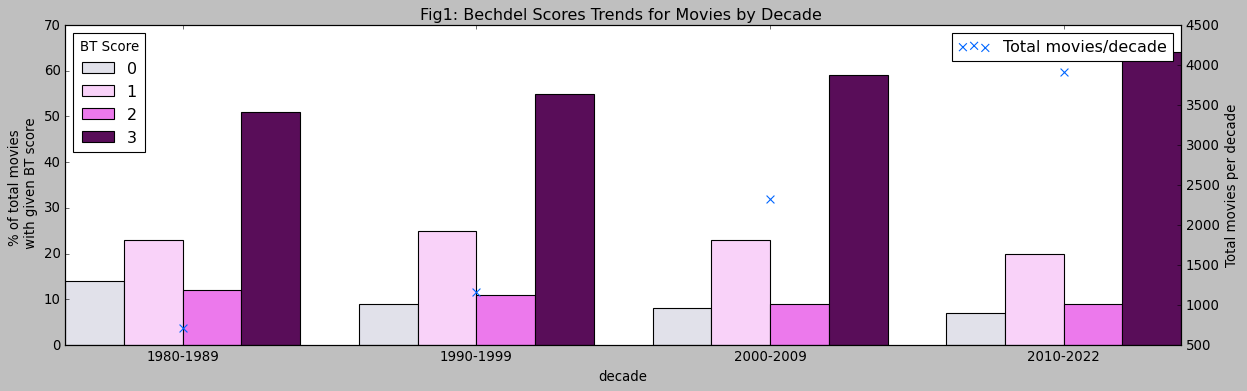

In [8]:
#analysis by decade
movies_per_decade = bt_movies.groupby("decade").size().to_frame().rename(columns = {0 :"size"})
movies_per_decade.index = movies_per_decade.index.astype('str')
movies_per_decade

movie_scores_per_decade = bt_movies.groupby(["decade","bechdel_score"], as_index = False).size().set_index("decade")
movie_scores_per_decade.index = movie_scores_per_decade.index.astype('str')
movie_scores_per_decade["percentage"] = (movie_scores_per_decade["size"] / movies_per_decade["size"] * 100).round()
movie_scores_per_decade

#visual
title_axis_labels = ["Fig1: Bechdel Scores Trends for Movies by Decade ",           #plot title
                     "% of total movies \n with given BT score",                    #yaxis label1 (left)
                     "Total movies per decade",                                     #xaxis label
                     "Total movies/decade",                                         #yaxis label2 (right)
                     "BechdelScoreTrendsbyDecade"]                                  #file name to save file

plot_base_bechdel((18,5), movie_scores_per_decade, movies_per_decade, "percentage", "size", 
                  title_axis_labels, "bechdel_score", ["#e0e0eb", "#ffccff", "#ff66ff", "#660066"], "#0066ff")

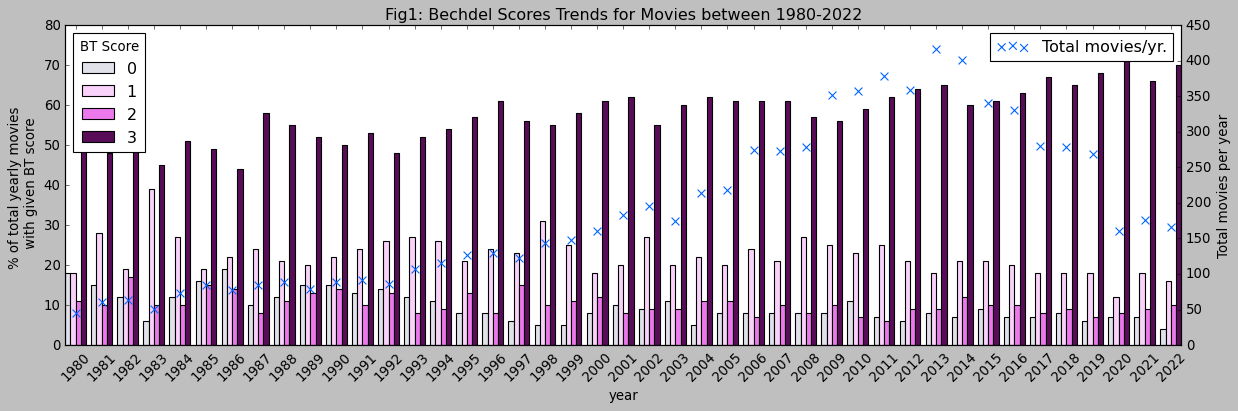

In [5]:
##analyis by year
movies_per_year = bt_movies.groupby("year").size().to_frame().rename(columns = {0 :"size"})
movies_per_year.index = movies_per_year.index.astype('str')
movies_per_year

movie_scores_per_year = bt_movies.groupby(["year","bechdel_score"], as_index = False).size().set_index("year")
movie_scores_per_year.index = movie_scores_per_year.index.astype('str')
movie_scores_per_year["percentage"] = (movie_scores_per_year["size"] / movies_per_year["size"] * 100).round()
movie_scores_per_year


#visual
# legend_labels = ["0: Fails Bechdel Test",  "1: Atleast 2 women", "2: Talking to each other", "3: ~abt a man (Passes BT)"]
title_axis_labels = ["Fig1: Bechdel Scores Trends for Movies between 1980-2022",    #plot title
                     "% of total yearly movies \n with given BT score",             #yaxis label1 (left)
                     "Total movies per year",                                       #xaxis label
                     "Total movies/yr.",                                            #yaxis label2 (right)
                     "YearlyBechdelScoreTrends"]                                    #file name to save file

plot_base_bechdel((18,5), movie_scores_per_year, movies_per_year, "percentage", "size", 
                  title_axis_labels, "bechdel_score", ["#e0e0eb", "#ffccff", "#ff66ff", "#660066"], "#0066ff");


##simplified bechdel scores to only show pass or fail
# movie_scores_per_year = bt_movies.groupby(["year","bt_pass_flag"], as_index = False).size().set_index("year")
# movie_scores_per_year.index = movie_scores_per_year.index.astype('str')
# movie_scores_per_year["perc"] = (movie_scores_per_year["size"] / movies_per_year["size"] * 100).round()
# movie_scores_per_year

# plot_base_bechdel(movie_scores_per_year, movies_per_year, "perc", "size", 
#                   "bt_pass_flag", ["#e0e0eb", "#660066"], "#0066ff")

<b>Observation: </b> An analysis of the Bechdel dataset from 1980 to 2022, shows an increase in the % of movies that meet all the BT criteria (BT score = 3) and the % of movies partially meeting the BT criteria (BT score = 1 or 2) or failing the BT test (BT score = 0) decreasing over the years. 


# 

# <a id='m2'></a>
### Module 2: Analysis of the Representativeness of the Bechdel Dataset using the IMDB Dataset

<a id='m2s1'></a>
<b>Section 1: Introduction: Is the Bechdel dataset truely representative?</b>

The Bechdel dataset is built based on [self reported data](https://bechdeltest.com/add/) and it is possible that only movies that do well on the Bechdel test are being reported. This would cause the Bechdel dataset to be baised and in such a case, the positive trends we see in this dataset may not converge with a broader and more representative dataset of Hollywood movies.

In order to test the representativeness of the Bechdel dataset, I tried to compare it to other freely available movie datasets. I chose the [IMDB movies dataset](https://developer.imdb.com/non-commercial-datasets/) since its freely available and covers the timeperiod I'm interested in. The IMDB movie data is also self reported and therefore suffers from its own biases but if at minimum, the IMDB dataset movies can be found in the Bechdel dataset then we know that the dataset covers different types of movies that people are watching (whether the movies are popular or unpopular on IMDB is not important at this stage; that fact that movies that are eliciting viewer responses are included in Bechdel would be a sufficient qualitative measure of representativeness for this project). 

We're only able to match about 20% of the IMB data with the Bechdel dataset as shown below which would indicate that the Bechdel dataset has a positive bias and is not fully representative of yhe universe of Hollywood movies from 1980 to 2022.

# <a id='m2s2'></a>
<b> Section 2: Data Sourcing, Cleaning and Transformation </b>

Two IMDB datasets have been used here:

* <b>movies_all:</b> contains all IMDB movie data; from this dataset we extract just movies (no TV shows, etc.) 
released between 1980 to 2022. This gives us approximately 380K records
* <b>movies_us:</b> We use the region and language features from this dataset to identify US english language movies (any time period). This gives us about ~3K records

Merging movies_all and movies_us gives us about 1K movies that are US based, in english and released between 1980 and 2022.
If a good proportion of these movies are also found in the Bechdel dataset, we can consider the later a representative dataset of Hollywood movies. However, as seen below, we are only able to match about 20% of this IMDB data to the Bechdel dataset.

In [9]:
## sourcing all IMDB data but we will condense it to just movies (no TV shows, etc.), between 1980 to 2022. 
## ~381,225records
movies_all = pd.read_csv("title.basics.tsv.gz", sep='\t', 
                     usecols = ["tconst", "titleType", "primaryTitle", "startYear", "genres"])
movies_all = movies_all[(movies_all.titleType == "movie")]            #analysis focuses on just movies ~648,658 records

movies_all["startYear"] = pd.to_numeric(movies_all["startYear"], errors ="coerce")  #there are some "\N" values in here 
movies_all =  movies_all[(movies_all.startYear >= 1980) & (movies_all.startYear < 2023)]   #only movies btw 1980-2022 ~381,225records
movies_all.drop_duplicates(subset = ["tconst"], inplace = True)  #~no duplicate records
movies_all["imdbid"] = [i[2:] for i in movies_all["tconst"]]
movies_all.drop(labels = ["tconst", "titleType"], axis =1, inplace = True)

movies_all.head()

,primaryTitle,startYear,genres,imdbid
11636,Tötet nicht mehr,2019.0,"Action,Crime",0011801
13082,Istoriya grazhdanskoy voyny,2021.0,Documentary,0013274
15178,La tierra de los toros,2000.0,\N,0015414
15486,Dama de noche,1993.0,"Drama,Mystery,Romance",0015724
34803,Kate & Leopold,2001.0,"Comedy,Fantasy,Romance",0035423


In [10]:
## Condensing this further by only focusing on US based and english language movies
movies_us = pd.read_csv("title.akas.tsv.gz", sep='\t', usecols = ["titleId", "title", "region","language"])
movies_us = movies_us[(movies_us["region"] == "US") & (movies_us["language"] == "en")]      
movies_us.drop_duplicates(subset = ["titleId"], inplace = True)  #~3173 unique records
movies_us["imdbid"] = [i[2:] for i in movies_us["titleId"]]
movies_us.drop(labels = ["titleId"], axis =1, inplace = True)

movies_us.head()

,title,region,language,imdbid
3402,Les Misérables,US,en,0000969
17472,The Governor,US,en,0005809
25715,Les Misérables,US,en,0008305
31872,Broken Blossoms,US,en,0009968
61305,Lost & Found,US,en,0016283


In [11]:
## merging movies_us with movies_all to get additional details on US EN movies
movies_us = movies_us.merge(movies_all, left_on = "imdbid", right_on= "imdbid", how ="inner")     #~1037 records
movies_us.drop(labels = ["primaryTitle"], axis =1, inplace = True)
movies_us.head()

,title,region,language,imdbid,startYear,genres
0,9 to 5,US,en,0080319,1980.0,Comedy
1,Star Wars: Episode V - The Empire Strikes Back,US,en,0080684,1980.0,"Action,Adventure,Fantasy"
2,Dracula's Last Rites,US,en,0081034,1980.0,Horror
3,The Lion of the Desert,US,en,0081059,1980.0,"Biography,Drama,History"
4,X-Ray,US,en,0082527,1981.0,"Horror,Thriller"


In [12]:
##merging with the bechdel dB to understand the coverage of the Bechdel dataset. The hope is that all or atleast 
##a good proportion of these movies would be in the Bechdel dataset. However, we're only able to match about 230 records
##I'm also surprised to see that its mostly recent movies that are missing. 
imdb_bechdel = movies_us.merge(bt_movies, left_on = "imdbid", right_on= "imdbid", how ="left")     # records
imdb_bechdel[~imdb_bechdel.bechdel_score.isna()].groupby("decade").size().to_frame().rename(columns = 
                                                                                                {0:"no. of missing"})

,no. of missing
decade,
1980-1989,12
1990-1999,22
2000-2009,31
2010-2022,164


# <a id='m3'></a>
### Module 3: Revenue Based Analysis

<a id='m3s1'></a>
<b> Section 1: Data Sourcing, Cleaning and Transformation </b>

For this section of the project, obtained  list of the top gross US movies is available from [the-numbers.com](https://www.the-numbers.com/box-office-records/domestic/all-movies/cumulative/all-time). Of these a few are outside of our time period (1980 to 2022 and so, have been removed from the dataset. This leaves us with 88 of the top grossing US movies based on domestic box office returns.

In [27]:
#https://www.the-numbers.com/box-office-records/domestic/all-movies/cumulative/all-time
#DO NOT reload from webpage. Note: Manually cleaned up movie names for the Star Wars, Pirates of the Caribbean, 
#Harry Potter series, etc. in the offline version

top_movies = pd.read_excel("boxoffice.xlsx", usecols= ["Rank","Year","Movie","Distributor","DomesticBoxOffice"])
top_movies = top_movies[(top_movies.Year>=2000) & (top_movies.Year <2023)]  #88 records; dropping 12 pre2000/post2022 movies
top_movies.DomesticBoxOffice = (top_movies.DomesticBoxOffice / 1000000).round()
top_movies["Rank"] = pd.Categorical(top_movies["Rank"], categories = np.arange(1,100), ordered = True)
# top_movies.head()

In [28]:
# top_movies.shape

In [29]:
## since the-numbers based data does not contain imdbids, I tried title based merge but stuff like Star Wars gets 
## messed up bec titles are not consisten in both dB. So, I tried incorporating imdbid
## When incorporating imbdids from movies_all, matching just on title leads to errors due to remakes for instance. 
## so we need to match on movie name AND year bec of remakes
top_movies = top_movies.merge(movies_all, left_on = ["Movie","Year"], 
                              right_on = ["primaryTitle","startYear"], how = "inner") 
top_movies[top_movies.imdbid.isna()]      # all matches after cleaning out movie names, e.g. Star Wars - vs : etc.



## However, two names have matched twice; manually reviewing and deleting the incorrect one
## ["Alice in Wonderland" keep "1014759", (https://www.imdb.com/title/tt1014759/?ref_=fn_al_tt_1) and remove 2049386
## and "Beauty and the Beast" keep "tt2771200" (https://www.imdb.com/title/tt2771200/?ref_=fn_al_tt_1) and remove 11861230
top_movies.Movie.value_counts()
top_movies = top_movies[~top_movies.imdbid.isin(["2049386","11861230"])]

# print(top_movies.shape[0])
# top_movies.head()

In [16]:
## Now that we have the imdbid, we can incorporate the bechdel data from bt_movies
top_movies = top_movies.merge(bt_movies, left_on = "imdbid", right_on = "imdbid", how = "left") 
top_movies[top_movies.imdbid.isna()].shape ##all match


#Simplifying the genres
# top_movies.sort_values("genres").genres.value_counts()
def simplified(x):
    if x.rfind(",") == -1:
        return x
    else:
        return x[:x.find(",")]
        
top_movies["simplified_genres"] = top_movies["genres"].apply(lambda x:simplified(x))


## Dropping the columns we don't need for further analysis
top_movies.drop(labels = ["primaryTitle", "startYear", "title", "genres"], axis = 1, inplace = True)

top_movies.head()

,Rank,Year,Movie,Distributor,DomesticBoxOffice,imdbid,bechdel_score,year,bt_pass_flag,decade,simplified_genres
0,1,2015,Star Wars: Episode VII - The Force Awakens,Walt Disney,937.0,2488496,3,2015,1,2010-2022,Action
1,2,2019,Avengers: Endgame,Walt Disney,858.0,4154796,3,2019,1,2010-2022,Action
2,3,2021,Spider-Man: No Way Home,Sony Pict…,814.0,10872600,3,2021,1,2010-2022,Action
3,4,2009,Avatar,20th Cent…,785.0,0499549,3,2009,1,2000-2009,Action
4,5,2022,Top Gun: Maverick,Paramount…,719.0,1745960,3,2022,1,2010-2022,Action


# <a id='m3s2'></a>
<b> Section 2: Relationship between Bechdel Scores and Box Office Returns </b>

Its one thing to talk about the importance of better gender representation but I was curious whether this is mostly just lip service and whether audiences are actually rewarding movies that do better on the Bechdel score with better box office numbers.

There are a lot of factors that go into making a successful movie such as cast, genre (America tends to prefer action/adventure movies but thats a project for another day, budget, marketing etc. and these factors are likely much more important predictors of a film's success. However, due to budget constraints (the-numbers.com was charging for more detailed data) and time constraints, I am limiting this project to just the analysis of the predictive power of Bechdel scores on a movies success

In [26]:
bo_bs_corr = top_movies[["DomesticBoxOffice","bechdel_score"]].corr().round(2).loc["DomesticBoxOffice","bechdel_score"]
top_movies[["DomesticBoxOffice","bechdel_score"]].corr().round(2)

,DomesticBoxOffice,bechdel_score
DomesticBoxOffice,1.0,0.2
bechdel_score,0.2,1.0


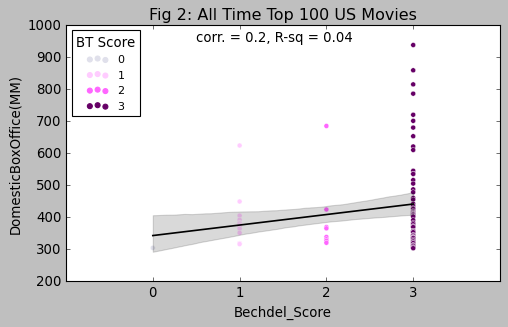

In [38]:
plt.figure(figsize = (7,4))
sns.scatterplot(data = top_movies, x ="bechdel_score", y = "DomesticBoxOffice", hue = "bechdel_score", 
                palette = ["#e0e0eb", "#ffccff","#ff66ff", "#660066"])
sns.regplot(data = top_movies, x ="bechdel_score", y = "DomesticBoxOffice", scatter = False, color = "black")
plt.title("Fig 2: All Time Top 100 US Movies");
plt.gca().ticklabel_format(axis='y', style='plain') 
plt.ylabel("DomesticBoxOffice(MM)")
plt.xlim(-1, 4, 1);
plt.gca().set_xticks([-1,0,1,2,3,4]);
plt.gca().set_xticklabels(["",0,1,2,3,""]);
plt.xlabel("Bechdel_Score")
plt.legend(loc = 2, fontsize = 10, title = "BT Score");
plt.text(0.5,950,"corr. = 0.2, R-sq = 0.04");
plt.savefig("BScoreBOReturns.png")

<b> Observation:</b> While there are likely a lot of factors that go into making a movie successful, such as the budget, plot/genre, cast, etc., it appears that bechdel scores do have some nominal predictive power about whether the movie will be a top grosser or not as shown in Table 1 (p = 0.012). It would be interesting to see how/if this relationship changes when better predictors are added to the model.

In [33]:
model = smf.ols("DomesticBoxOffice ~ bechdel_score", data = top_movies).fit()
model.get_robustcov_results().summary() #.tables[1]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      DomesticBoxOffice   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     6.624
Date:                Wed, 02 Aug 2023   Prob (F-statistic):             0.0118
Time:                        13:24:38   Log-Likelihood:                -555.50
No. Observations:                  88   AIC:                             1115.
Df Residuals:                      86   BIC:                             1120.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       341.5739     28.106     12.153      0.000     285.701     397.447
bechdel_score    32.8363     12.759      2.574      0.012       7.473      58.200
==============================================================================
Omnibus:                       37.513   Durbin-Watson:                   0.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.674
Skew:                           1.732   Prob(JB):                     7.42e-16
Kurtosis:                       5.647   Cond. No.                         9.86
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [23]:
# print((top_movies.bt_pass_flag.value_counts()/top_movies.shape[0] * 100).round())

# plt.figure(figsize = (5,5))
# # sns.scatterplot(data = top_movies, x ="bt_pass_flag", y = "DomesticBoxOffice", hue = "bt_pass_flag", 
# #                 palette = ["#e0e0eb", "#660066"]).set_title("Fig 3B-2: All Time Top 100 US Movies");
# sns.regplot(data = top_movies, x ="bechdel_score", y = "DomesticBoxOffice", 
#           scatter_kws = {"color": "#ffccff"},
#           line_kws = {"color": "#660066"})
# plt.title("Fig 3B-2: All Time Top 100 US Movies");

# plt.gca().ticklabel_format(axis='y', style='plain') 
# plt.ylabel("DomesticBoxOffice(MM)")
# # plt.xlim(-1, 2, 1);
# # plt.gca().set_xticks([-1,0,1,2]);
# # plt.gca().set_xticklabels(["","Fail","Pass",""]);
# plt.xlabel(None);
# # plt.legend(loc = 2);
# # plt.savefig("BTFlagByBOReturns.png")

### References:

1. https://glaad.org/whereweareontv21

2. https://dykestowatchoutfor.com/the-rule/

3. https://bechdeltest.com/

4. https://developer.imdb.com/non-commercial-datasets/

5. https://bechdeltest.com/api/v1/doc#getAllMovies

6. https://www.the-numbers.com/box-office-records/domestic/all-movies/cumulative/all-time

<a id='appendix1'></a>
### Appendix

The below code was used for the API call from thebechdeltest.com

In [ ]:
# url = "http://bechdeltest.com/api/v1/getAllMovies?"
# response = urlopen(url)
# data_json = json.loads(response.read())

# btid_lst = []
# imdbid_lst = []
# title_lst = []
# rating_lst = []
# year_lst = []

# for i in data_json:
#     btid_lst.append(i["id"])
#     imdbid_lst.append(i["imdbid"])
#     title_lst.append(i["title"])
#     rating_lst.append(i["rating"])
#     year_lst.append(i["year"])

# bt_movies_original = pd.DataFrame({"btid": btid_lst, "imdbid": imdbid_lst, "title": title_lst, 
#                                    "bechdel_score": rating_lst, "year": year_lst})


##writing to file so we don't have to call the API again
# bt_movies_original.to_pickle('bt_movies_original.pkl')  #full dataset  ~10K records as of JuLy 7th


##subset of movies from 1980 to 2022YE only
# bt_movies_orig_subset = bt_movies_original[(bt_movies_original.year >= 1980) & (bt_movies_original.year < 2023)] #~8113 records
# bt_movies_orig_subset.to_pickle('bt_movies_orig_subset.pkl')  #as backup  ~8K records as of JuLy 7th


# Note: to_csv was casting imdbids to floats so beginning 0s were lost. E.g. 01234 was saved as 1234. 
# So I'm just using pickle instead
# bt_movies.to_csv("bt_movies.csv", float_format = "string") 
# types = defaultdict(str, imdbid = "str", rating ="int", year = "int")
# bt_movies = pd.read_csv("bt_movies.csv", dtype=types) #8113 records from 1980-2022"""

In [ ]:
# Theres a lot of other interesting data on the internet on this topic/ related areas (some of it is paid and so eliminated from consideration for this project :\) or  (2) from 
